In [1]:
import fasttext.util
import pandas as pd

import torch

from transformers import BertTokenizer

from sklearn.model_selection import train_test_split

from transformers import BertModel

import torch.nn as nn

from torch.utils.data import DataLoader, TensorDataset

import torch.optim as optim

import numpy as np

from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print(torch.cuda.is_available())  # Should print True if CUDA is detected

print(torch.cuda.device_count())  # Should return the number of GPUs available

print(torch.cuda.get_device_name(0))  # Should print the name of the GPU (e.g., NVIDIA GeForce RTX 4060)
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
data = pd.read_csv("/kaggle/input/cyberguard/Modified_Data.csv")
# Load FastText embeddings (300 dimensions)
fasttext.util.download_model('en', if_exists='ignore')
ft = fasttext.load_model('cc.en.300.bin')

# Convert text to FastText embeddings
def embed_text_with_fasttext(text):
    tokens = text.split()  # Whitespace tokenizer
    embeddings = [ft.get_word_vector(word) for word in tokens]
    if embeddings:
        return np.mean(embeddings, axis=0)  # Average to get a fixed 300-dim embedding per text
    else:
        return np.zeros(300)  # If no tokens, return a zero vector

# Apply to the dataset
data["embedding"] = data["crimeaditionalinfo"].apply(embed_text_with_fasttext)

# Split data
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

# Convert embeddings and labels to tensors
train_embeddings = torch.tensor(np.stack(train_data["embedding"].values)).float()
train_labels_category = torch.tensor(train_data["category"].values).long()
train_labels_sub_category = torch.tensor(train_data["sub_category"].values).long()

val_embeddings = torch.tensor(np.stack(val_data["embedding"].values)).float()
val_labels_category = torch.tensor(val_data["category"].values).long()
val_labels_sub_category = torch.tensor(val_data["sub_category"].values).long()

# Create datasets and data loaders
train_dataset = TensorDataset(train_embeddings, train_labels_category, train_labels_sub_category)
val_dataset = TensorDataset(val_embeddings, val_labels_category, val_labels_sub_category)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)


True
2
Tesla T4
 (100.00%) [==================================================>]


# MODEL CREATION

In [2]:
class MultiTaskModel(nn.Module):
    def __init__(self, input_dim, num_labels_task1, num_labels_task2):
        super(MultiTaskModel, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.dropout = nn.Dropout(0.3)
        self.classifier_task1 = nn.Linear(256, num_labels_task1)
        self.classifier_task2 = nn.Linear(256, num_labels_task2)

    def forward(self, embeddings, labels_task1=None, labels_task2=None):
        x = self.fc1(embeddings)
        x = self.dropout(torch.relu(x))
        
        logits_task1 = self.classifier_task1(x)
        logits_task2 = self.classifier_task2(x)

        loss = None
        if labels_task1 is not None and labels_task2 is not None:
            loss_fn = nn.CrossEntropyLoss()
            loss_task1 = loss_fn(logits_task1, labels_task1)
            loss_task2 = loss_fn(logits_task2, labels_task2)
            loss = loss_task1 + loss_task2

        return {"loss": loss, "logits_task1": logits_task1, "logits_task2": logits_task2}

# Initialize model
input_dim = 300  # FastText embedding dimension
num_labels_task1 = 15
num_labels_task2 = 35
model = MultiTaskModel(input_dim=input_dim, num_labels_task1=num_labels_task1, num_labels_task2=num_labels_task2)
model.to(device)


MultiTaskModel(
  (fc1): Linear(in_features=300, out_features=256, bias=True)
  (dropout): Dropout(p=0.3, inplace=False)
  (classifier_task1): Linear(in_features=256, out_features=15, bias=True)
  (classifier_task2): Linear(in_features=256, out_features=35, bias=True)
)

# TRAINING LOOP

Epoch 1 - Training Loss: 2.8135854377897718
Task 1 - Training Accuracy: 0.7313914928437101, Validation Accuracy: 0.758656330749354
Task 2 - Training Accuracy: 0.36751891356465066, Validation Accuracy: 0.4405397645707723
Epoch 2 - Training Loss: 2.7458428158863293
Task 1 - Training Accuracy: 0.7307024217976141, Validation Accuracy: 0.7567039908125179
Task 2 - Training Accuracy: 0.3793479665226317, Validation Accuracy: 0.3943152454780362
Epoch 3 - Training Loss: 2.749194481549977
Task 1 - Training Accuracy: 0.7315781162520277, Validation Accuracy: 0.746195808211312
Task 2 - Training Accuracy: 0.3808696650827603, Validation Accuracy: 0.42492104507608386
Epoch 4 - Training Loss: 2.7413003970353387
Task 1 - Training Accuracy: 0.7324394550596477, Validation Accuracy: 0.7534309503301752
Task 2 - Training Accuracy: 0.3804677069725376, Validation Accuracy: 0.41693942004019524
Epoch 5 - Training Loss: 2.74792267009787
Task 1 - Training Accuracy: 0.7310756686142494, Validation Accuracy: 0.7606660

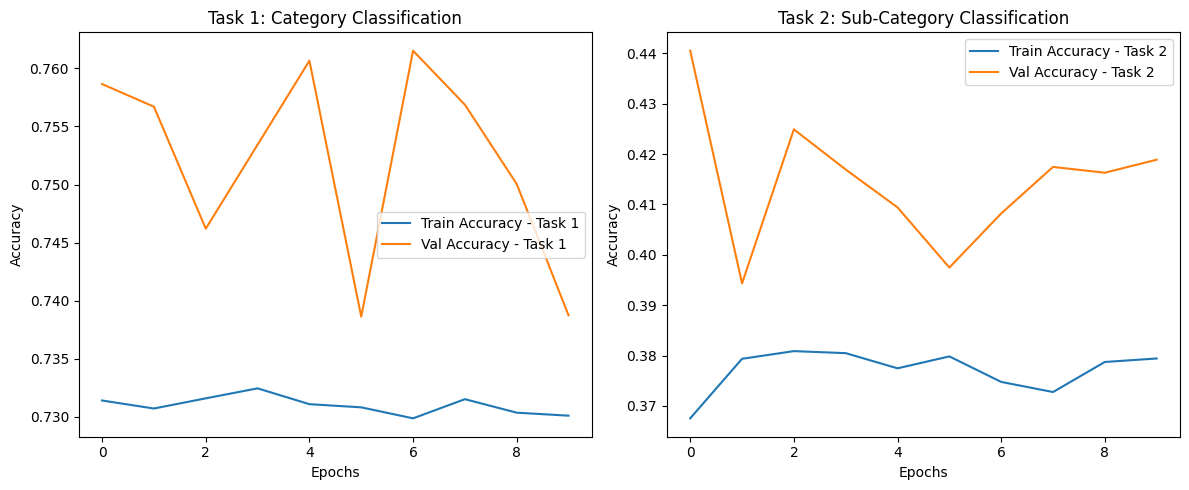

In [3]:
# Optimizer
optimizer = optim.AdamW(model.parameters(), lr=2e-2)

# Training and Validation Loops
train_accuracies_task1, train_accuracies_task2 = [], []
val_accuracies_task1, val_accuracies_task2 = [],[]

for epoch in range(10):
    model.train()
    total_train_loss = 0
    train_preds_task1, train_preds_task2 = [], []
    train_labels_task1, train_labels_task2 = [], []

    for batch in train_loader:
        embeddings = batch[0].to(device)
        labels_task1 = batch[1].to(device)
        labels_task2 = batch[2].to(device)

        # Forward pass
        outputs = model(embeddings, labels_task1, labels_task2)
        loss = outputs["loss"]
        total_train_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        train_preds_task1.extend(torch.argmax(outputs["logits_task1"], axis=1).cpu().numpy())
        train_preds_task2.extend(torch.argmax(outputs["logits_task2"], axis=1).cpu().numpy())
        train_labels_task1.extend(labels_task1.cpu().numpy())
        train_labels_task2.extend(labels_task2.cpu().numpy())

    # Calculate training accuracy
    train_accuracy_task1 = accuracy_score(train_labels_task1, train_preds_task1)
    train_accuracy_task2 = accuracy_score(train_labels_task2, train_preds_task2)
    train_accuracies_task1.append(train_accuracy_task1)
    train_accuracies_task2.append(train_accuracy_task2)

    # Validation
    model.eval()
    val_preds_task1, val_preds_task2 = [], []
    val_labels_task1, val_labels_task2 = [], []
    with torch.no_grad():
        for batch in val_loader:
            embeddings = batch[0].to(device)
            labels_task1 = batch[1].to(device)
            labels_task2 = batch[2].to(device)

            outputs = model(embeddings)
            val_preds_task1.extend(torch.argmax(outputs["logits_task1"], axis=1).cpu().numpy())
            val_preds_task2.extend(torch.argmax(outputs["logits_task2"], axis=1).cpu().numpy())
            val_labels_task1.extend(labels_task1.cpu().numpy())
            val_labels_task2.extend(labels_task2.cpu().numpy())

    # Calculate validation accuracy
    val_accuracy_task1 = accuracy_score(val_labels_task1, val_preds_task1)
    val_accuracy_task2 = accuracy_score(val_labels_task2, val_preds_task2)
    val_accuracies_task1.append(val_accuracy_task1)
    val_accuracies_task2.append(val_accuracy_task2)

    print(f"Epoch {epoch+1} - Training Loss: {total_train_loss / len(train_loader)}")
    print(f"Task 1 - Training Accuracy: {train_accuracy_task1}, Validation Accuracy: {val_accuracy_task1}")
    print(f"Task 2 - Training Accuracy: {train_accuracy_task2}, Validation Accuracy: {val_accuracy_task2}")

# Plotting
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_accuracies_task1, label='Train Accuracy - Task 1')
plt.plot(val_accuracies_task1, label='Val Accuracy - Task 1')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Task 1: Category Classification')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies_task2, label='Train Accuracy - Task 2')
plt.plot(val_accuracies_task2, label='Val Accuracy - Task 2')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Task 2: Sub-Category Classification')
plt.legend()

plt.tight_layout()
plt.show()
